# Extended Taxi problem 

In this project we will implement the basic Taxi problem  with added gas station and slippery fields.

The taxi moves along the 5x5 grid. 
Its task consists of three phases: 
1. Finding the passenger: going to one of the 4 stations (R, G, Y, B) where the passenger is.
2. Executing the PICKUP action
3. Going towards the destination and executing a DROPOFF action

Additions to the problem:
1. Resource Management (Fuel): Each movement consumes 1 unit of fuel. If the fuel reaches 0, the taxi stops and the episode ends in failure. The agent must learn when to turn to the gas station.
2. Stochasticity (Ice): On certain fields (ice patches), the taxi can slip. This means that the agent gives the command "Go North", but ends up e.g. "East". This teaches the agent to avoid those fields or plan for failure.
3. Avoiding obstacles(Walls): Fields that fully block movement

Algorithms:

1. Q-Learning
2. Monte Carlo 
3. SARSA

# Basic Imports

In [143]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.patches as patches

# Custom Taxi Environment With Fuel

**Our custom environment will inherit from gymnasium.Env that defines the structure all environments must follow**

Fuel: max 10 units (0-9)

Passenger location: 0=R, 1=G, 2=Y, 3=B, 4=in taxi.

Destination: 0=R, 1=G, 2=Y, 3=B

State is defined by **[row(taxi position), column(taxi position), passenger_location, destination, fuel]**

Actions:

    0-> N
    1-> S
    2-> E
    3-> W
    4->PICKUP
    5->DROPOFF
    6->REFUEL

Reward system:

    -1 per step unless other reward is triggered

    -5 if the taxi hits the border or inside walls(obstacles)

    +10 successful pickup

    -10 unsuccessful pickup or dropoff

    +50 delivering passenger

    -50 for running out of fuel before the end of the episode


In [144]:
class TaxiFuelEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.grid_size = 5
        self.fuel_limit = 9

        # MultiDiscrete - Supports multiple discrete values with multiple axes, used for controller actions
        self.observation_space = spaces.MultiDiscrete([5, 5, 5, 4, 10]) #5 rows and columns, 5 passenger locations, 4 destinations, 25 units of fuel

        self.action_space = spaces.Discrete(7)
        self.locs = [(0,0), (0,4), (4,0), (4,3)] # R, G, Y, B
        self.gas_station = (2,2) 
        self.ice_patches = [(1, 1), (1, 3), (3, 2)] #slippery sections
        self.walls = [(0, 1), (3, 3), (3, 0)]  #walls, obstacles
        

    
    def _is_wall_between(self, pos1, pos2):
        """Return True if there is a wall segment between two adjacent cells."""
        return frozenset([tuple(pos1), tuple(pos2)]) in self.walls
    
    def reset(self, seed = None):
        super().reset(seed=seed)
        self.pass_idx = np.random.randint(0,4)  #the passenger is at one of these positions in the beginning: R, Y, B, G

        # Pick a random destination location that is NOT the passenger location
        self.dest_idx = np.random.randint(0, 4)
        while self.dest_idx == self.pass_idx:
            self.dest_idx = np.random.randint(0, 4)  

        # Pick a random taxi position that is not the same as ice or passenger location
        pass_pos = self.locs[self.pass_idx]
        dest_pos = self.locs[self.dest_idx]
        while True:
            self.taxi_pos = [np.random.randint(0, 5), np.random.randint(0, 5)]
            t = tuple(self.taxi_pos)
            if (t != pass_pos and
                t != dest_pos and
                t not in self.ice_patches and 
                t not in self.locs and  # dont put taxi ar RGBY
                t not in self.walls and #dont put at wall 
                t not in self.gas_station):   #dont start at gas station 
                break
            
        self.fuel = self.fuel_limit  #starting with maximum fuel
        return self._get_obs(), {}
    
    def _get_obs(self):
        #convert internal state to observation format
        return (self.taxi_pos[0], self.taxi_pos[1], self.pass_idx, self.dest_idx, self.fuel)
    
    def step(self, action):
        reward = -1 
        done = False

        #slippery sections
        #if the taxi steps on ice and wants to go N, he will actually go W for example
        if tuple(self.taxi_pos) in self.ice_patches and action < 4:
            if np.random.rand() < 0.3:
                possible_moves = [0,1,2,3]
                possible_moves.remove(action) #dont choose the same action
                action = np.random.choice(possible_moves)


        #ACTIONS

        #regular movement
        if action < 4:
            old_pos = list(self.taxi_pos)
            new_pos = list(self.taxi_pos)
 
            if action == 0:   new_pos[0] = max(0, self.taxi_pos[0] - 1)   #taxi cant go past the borders of the 5x5 grid, so we use the max or min function
            elif action == 1: new_pos[0] = min(4, self.taxi_pos[0] + 1) 
            elif action == 2: new_pos[1] = min(4, self.taxi_pos[1] + 1)  
            elif action == 3: new_pos[1] = max(0, self.taxi_pos[1] - 1) 
            

            # check if the taxi hit an inner wall
            if tuple(new_pos) in self.walls:
                reward = -5 # punishment for hitting the inner wall
            elif new_pos == old_pos:
                reward = -5 # punishment for hitting the outside wall (border)
                self.taxi_pos = new_pos
            else:
                reward = -1 #standard reward for movement
                self.taxi_pos = new_pos
                
            self.fuel -= 1 # with each step, one unit of fuel is decreased

        #pickup
        elif action == 4: 
            if self.pass_idx < 4 and tuple(self.taxi_pos) == self.locs[self.pass_idx]:
                self.pass_idx = 4   #in taxi
                reward = 10
            else:
                reward = -10

        #dropoff
        elif action == 5:
            if self.pass_idx == 4 and tuple(self.taxi_pos) == self.locs[self.dest_idx]:
                reward = 50
                done = True
            else:
                reward = -10


        #refuel
        elif action == 6:
            if tuple(self.taxi_pos) == self.gas_station:
                self.fuel = self.fuel_limit
                reward = -1
            else:
                reward = -10

        if self.fuel <= 0 and not done:
            reward = -50
            done = True

        
        return self._get_obs(), reward, done, False, {}




# Q Learning Agent

In [145]:
class QLearningAgent:
    def __init__(self, n_actions):
        ''' 
            n_actions - number of possible actions
            alpha - learning rate
            gamma - discount factor
            epsilon - probability of a random action
            Q - Q table
        '''

        self.n_actions = n_actions
        self.alpha = 0.1
        self.gamma = 0.99
        # When epsilon = 1, the epsilon-greedy policy chooses actions completely randomly, so it is equivalent to a random policy.
        self.epsilon = 1.0   
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01

        # Q table ->  Q[x_i][xdot_i][θ_i][θdot_i][action]
        #self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.Q = defaultdict(lambda: np.ones(n_actions) * 5.0)


    def choose_action(self, state):
        '''
            Actions are selected using an epsilon-greedy policy,
            so that exploration and exploitation are balanced.
        '''
        if np.random.rand() < self.epsilon:   
            # Exploration - choose a random action
            return np.random.randint(self.n_actions)
        # Exploitation with probability 1-epsilon, the agent is using his current knowledge to maximize rewards
        return np.argmax(self.Q[state]) 
    
    def update(self, s, a, r, s_next, done):
        '''Q-values are updated using the Bellman optimality equation
            s - state
            a - action
            r - reward
            s_next - next state
        '''
        # If done, max is 0
        max = 0 if done else np.max(self.Q[s_next])
        self.Q[s][a] += self.alpha * (r + self.gamma * max - self.Q[s][a])

# Training

In [146]:
env = TaxiFuelEnv()
agent = QLearningAgent(env.action_space.n)

episodes = 30000
episode_rewards = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _, _= env.step(action)

        agent.update(state, action, reward, next_state, done)  # update Q values

        state = next_state
        total_reward += reward

        if done:
            break

    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
    episode_rewards.append(total_reward)


# Test

Function for visualization: 

In [147]:
plt.rcParams['font.family'] = ['Segoe UI Emoji', 'DejaVu Sans']
def visualize(env, for_ice_test=False):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xticks(range(6))
    ax.set_yticks(range(6))
    ax.set_xticklabels(range(6))
    ax.set_yticklabels(list(range(5, -1, -1)))
    ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)

    colors = ['red', 'green', 'yellow', 'blue']
    names = ['R', 'G', 'Y', 'B']
    for i, (r, c) in enumerate(env.locs):
        ax.add_patch(patches.Rectangle((c, 4-r), 1, 1, color=colors[i], alpha=0.3))
        ax.text(c+0.4, 4-r+0.4, names[i], fontsize=14, fontweight='bold')

    pr, pc = env.gas_station
    ax.add_patch(patches.Rectangle((pc, 4-pr), 1, 1, color='black', alpha=0.8))
    ax.text(pc+0.1, 4-pr+0.4, 'GAS STATION', color='white', fontsize=9, fontweight='bold')

    for (ir, ic) in env.ice_patches:
        ax.add_patch(patches.Rectangle((ic, 4-ir), 1, 1, color='skyblue', alpha=0.6))
        ax.text(ic+0.2, 4-ir+0.4, 'ICE', color='darkblue', fontsize=10)

    
    for (wr, wc) in env.walls:
        ax.add_patch(patches.Rectangle((wc, 4-wr), 1, 1, color='gray', hatch='///'))
        ax.text(wc+0.3, 4-wr+0.4, 'WALL', color='white', fontsize=8, fontweight='bold')

    tr, tc = env.taxi_pos
    #ax.add_patch(patches.Circle((tc+0.5, 4-tr+0.5), 0.3, color='gold', ec='black', lw=2, zorder=5))
    #ax.text(tc+0.35, 4-tr+0.45, 'x', fontsize=18, zorder=6)
    ax.text(tc+0.2, 4-tr+0.3, '🚕', fontsize=25, zorder=10)


    passenger_status = ""
    destination = ""
    if env.pass_idx < 4:
        pr, pc = env.locs[env.pass_idx]
        #ax.text(pc+0.7, 4-pr+0.1, 'o', fontsize=15)
        ax.text(pc+0.5, 4-pr+0.3, '🧍', fontsize=20)
        passenger_status = f"Passenger is at location: {names[env.pass_idx]}"
        destination = f"Destination: {names[env.dest_idx]}"
    elif for_ice_test:
        passenger_status = ""
        destination = ""
    else:
        passenger_status = "Passenger is IN THE TAXI"
        destination = f"Destination: {names[env.dest_idx]}"

    dr, dc = env.locs[env.dest_idx]
    ax.text(dc+0.1, 4-dr+0.7, '🏁', fontsize=20)
        

    plt.title(f"Status: {passenger_status} |  {destination} | Fuel: {env.fuel}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



Visualizing ice patches to see if the taxi slips when on them

Taxi starts from (1,2), moves to (1,3) which is an ice patch, then tries to go south

In [148]:
def test_ice_logic(env):
    env.reset()
    slipped = False

    print("--- Start: Taxi is at (1, 2) ---")
    env.taxi_pos = [1, 2]
    visualize(env, for_ice_test=True)

    env.step(2) # 2: East
    print("--- Step 1: Taxi moved to (1, 3) which is ICE ---")
    visualize(env, for_ice_test=True)

    while not slipped:
        env.taxi_pos = [1, 3]
        env.fuel = 10
        
        intended_action = 1 # South 
        env.step(intended_action)
        
        #If the taxi is not on (2,3), it slipped
        if tuple(env.taxi_pos) != (2, 3):
            print(f"--- Step 2: SLIP OCCURRED! Intended South, but taxi ended at {env.taxi_pos} ---")
            visualize(env, for_ice_test=True)
            slipped = True



Testing inside walls

In [149]:
def test_wall_logic(env):
    """Verify that a wall segment blocks movement as expected."""
    env.reset()

    # Place taxi just to the left of Wall D: (3,0) → trying to go East → (3,1) is blocked
    env.taxi_pos = [0, 2]
    env.fuel = 9
    print("--- Wall test: Taxi at (0,2), trying to move West ---")
    visualize(env, for_ice_test=True)

    old_pos = list(env.taxi_pos)
    obs, reward, done, _, _ = env.step(3) 
    new_pos = list(env.taxi_pos)

    if new_pos == old_pos and reward == -5:
        print(f"Wall correctly blocked movement! Taxi stayed at {new_pos}, reward={reward}")
    else:
        print(f"Wall test failed. Taxi moved to {new_pos}, reward={reward}")

 
    

Simulating steps

Actions are greedy

In [150]:
def simulate_agent(env, agent):
    state, _ = env.reset()
    visualize(env)
    done = False
    step_count = 0
    
    while not done and step_count < 50:
        action = np.argmax(agent.Q[state]) # Greedy action
        state, reward, done, _, _ = env.step(action)
        visualize(env)
        step_count += 1
        if done: print("Mission Accomplished!")



Function that tests the perfomance of our trained agent

In [151]:
def test_performance(env, agent, num_episodes=2000):
    successes = 0
    fuel_deaths = 0
    total_steps_all = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        steps_this_ep = 0
        
        while not done and steps_this_ep < 200: 
            action = np.argmax(agent.Q[state]) 
            state, reward, done, _, _ = env.step(action)
            steps_this_ep += 1
            
            if reward == 50: # successful dropoff
                successes += 1
            if reward == -50: #ran out of gas
                fuel_deaths += 1
        
        total_steps_all += steps_this_ep

    print(f"--- Test Results over {num_episodes} episodes ---")
    print(f"Success Rate: {(successes/num_episodes)*100:.2f}%")
    print(f"Fuel Depletion Rate: {(fuel_deaths/num_episodes)*100:.2f}%")
    print(f"Average Steps: {total_steps_all/num_episodes:.2f}")

In [ ]:
# Training statistics
avg_reward = np.mean(episode_rewards)
max_reward = np.max(episode_rewards)
min_reward = np.min(episode_rewards)

print(f"Training statistics over {episodes} episodes:")
print(f"Average reward per episode: {avg_reward:.2f}")
print(f"Maximum reward achieved: {max_reward}")
print(f"Minimum reward achieved: {min_reward}")

Training statistics over 30000 episodes:
Average reward per episode: -10.55
Maximum reward achieved: 53
Minimum reward achieved: -368


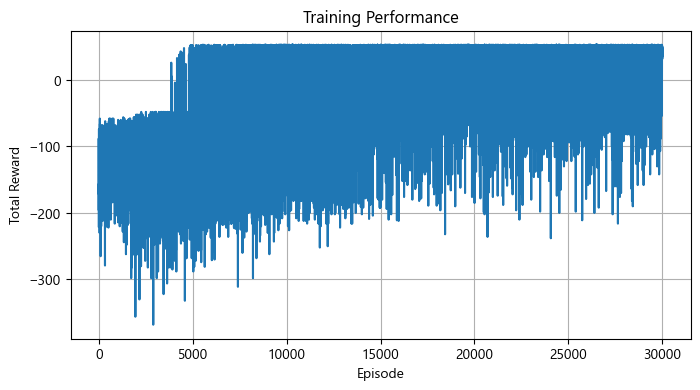

In [153]:
plt.figure(figsize=(8,4))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid()
plt.show()

--- Start: Taxi is at (1, 2) ---


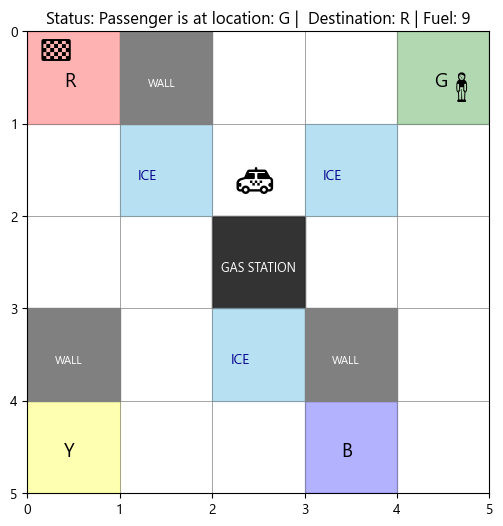

--- Step 1: Taxi moved to (1, 3) which is ICE ---


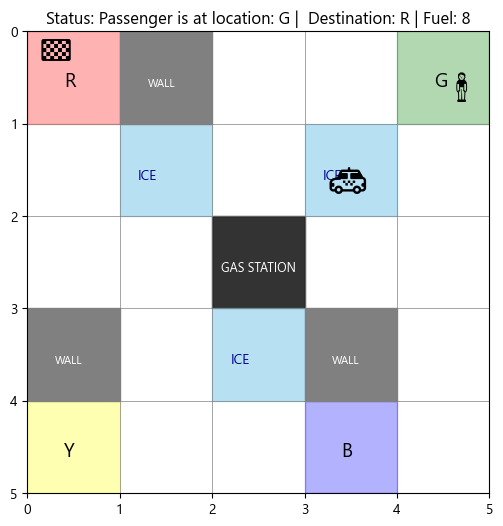

--- Step 2: SLIP OCCURRED! Intended South, but taxi ended at [1, 2] ---


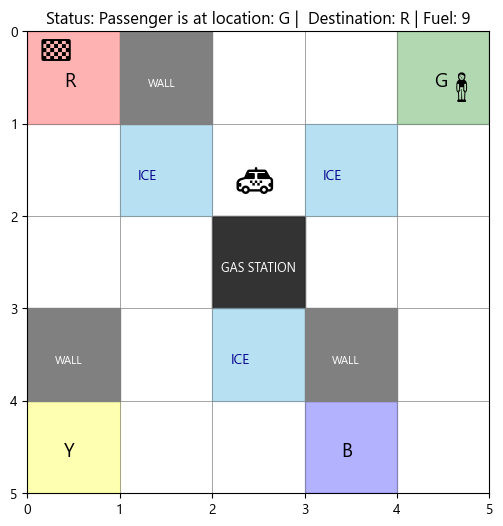

In [154]:
test_ice_logic(env)

--- Wall test: Taxi at (0,2), trying to move West ---


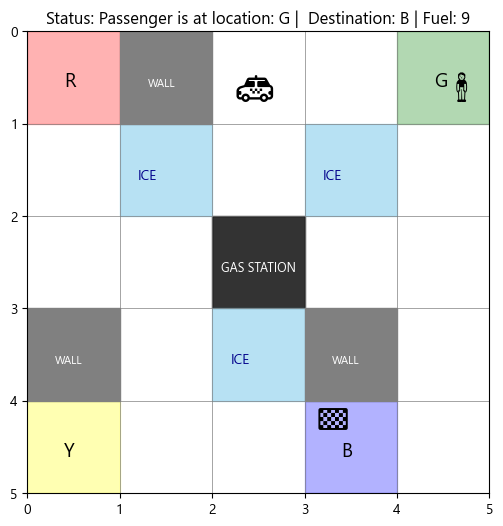

Wall correctly blocked movement! Taxi stayed at [0, 2], reward=-5


In [155]:
test_wall_logic(env)

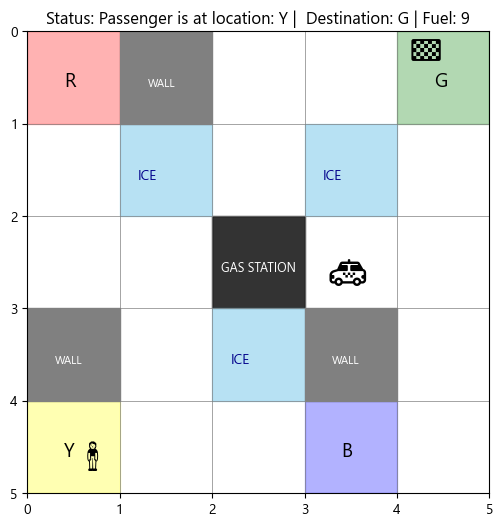

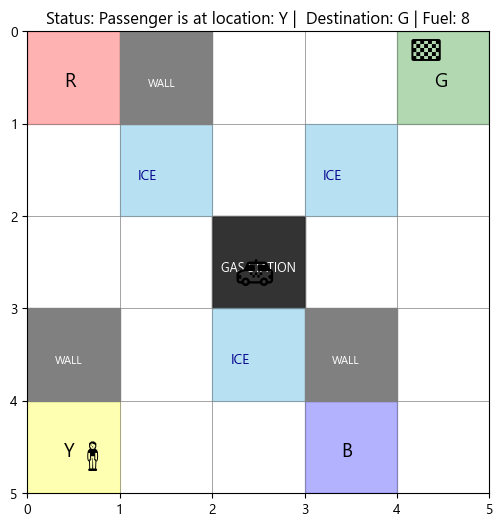

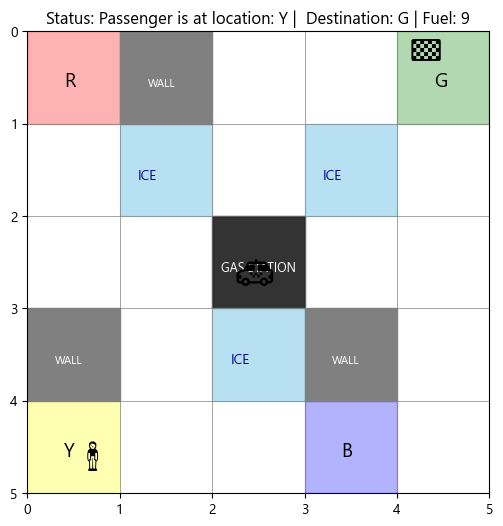

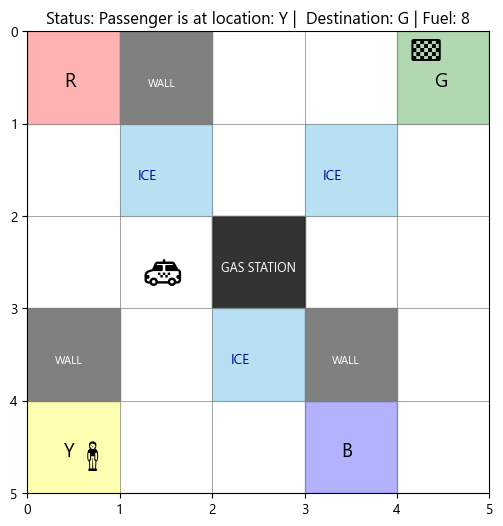

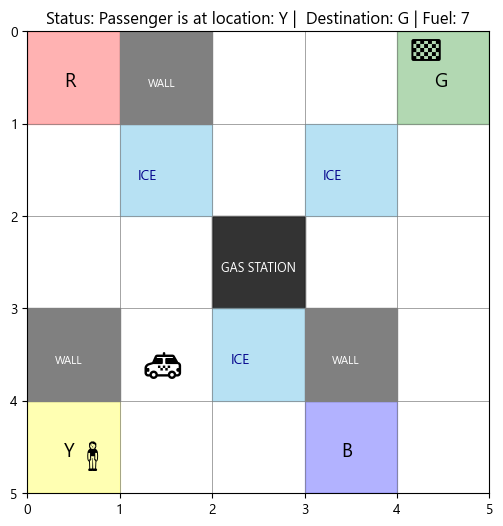

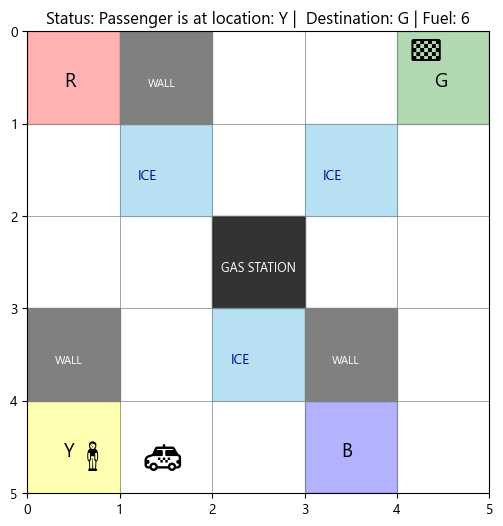

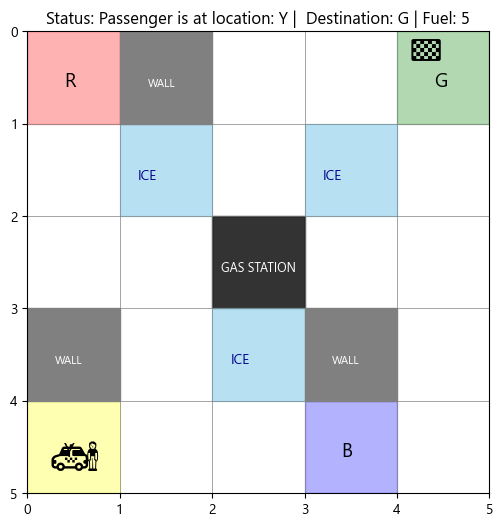

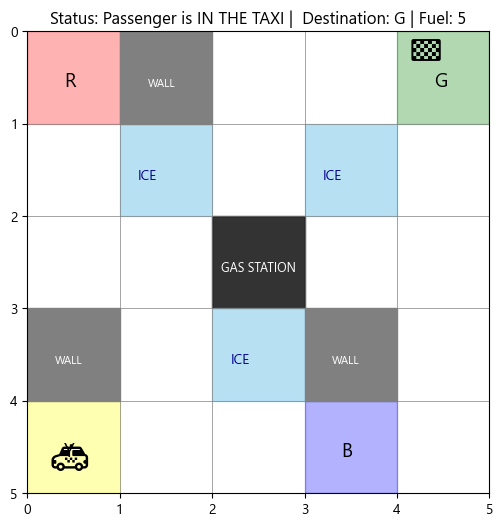

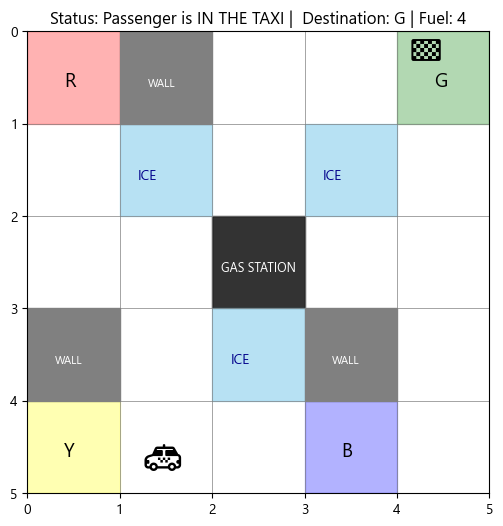

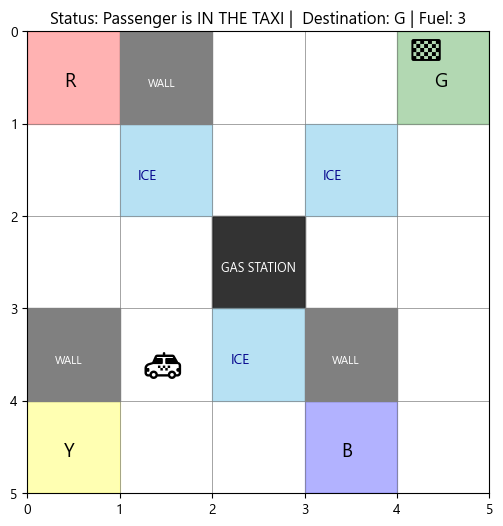

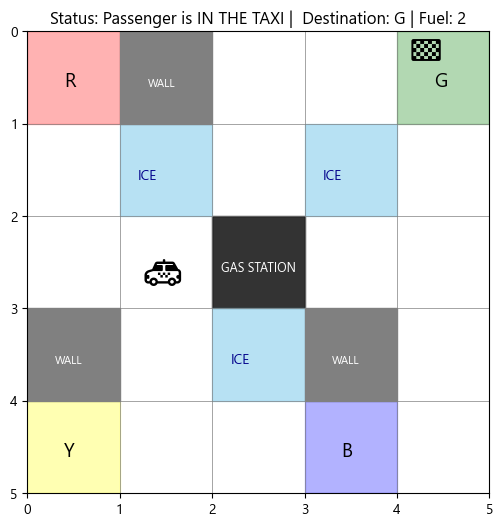

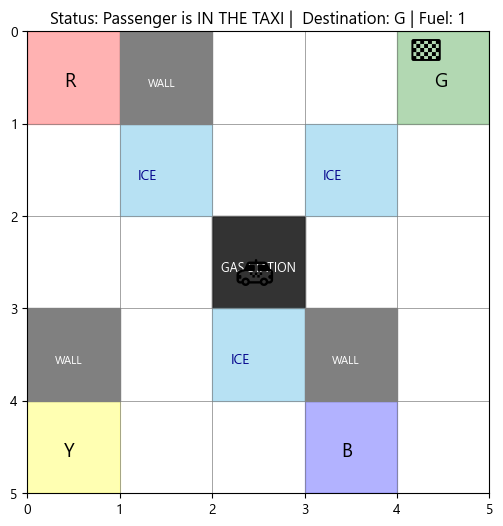

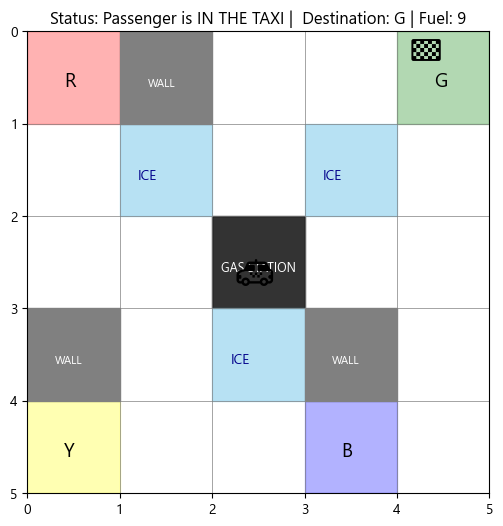

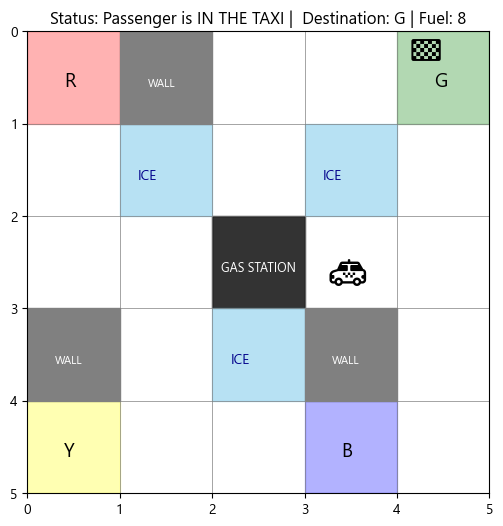

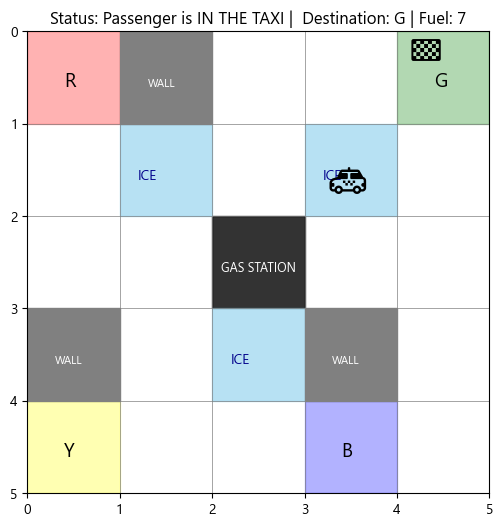

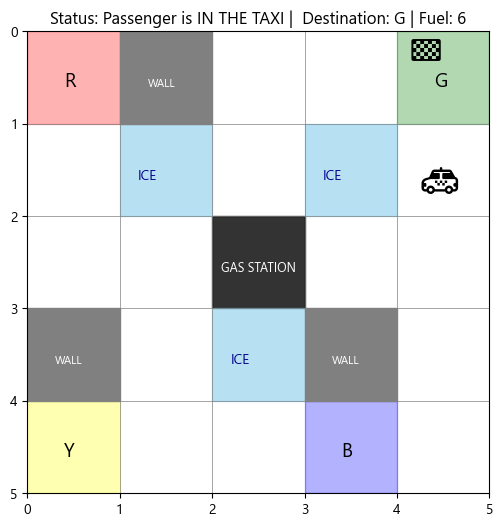

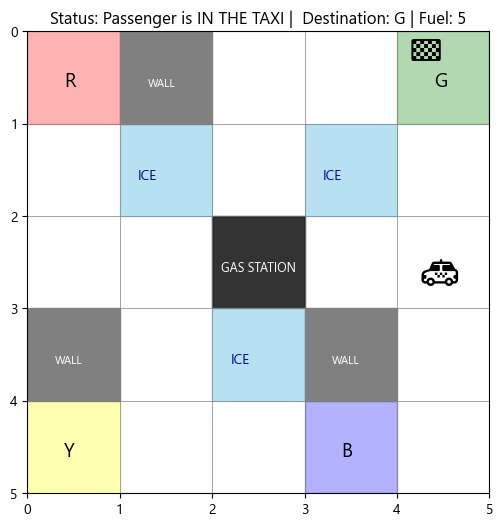

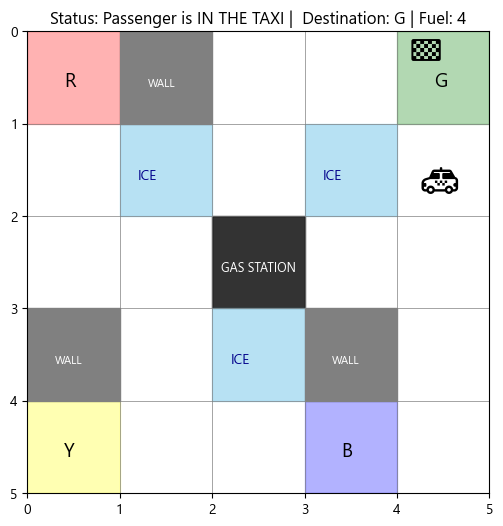

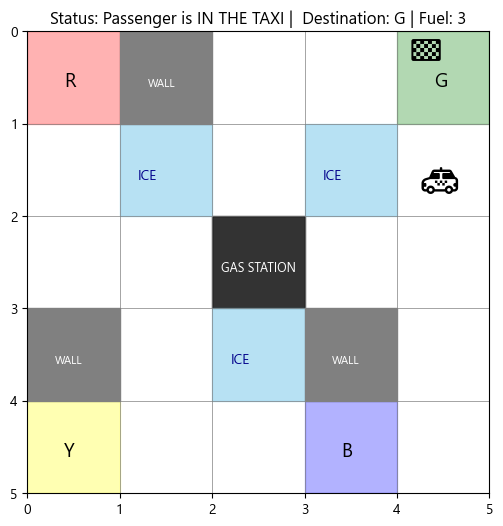

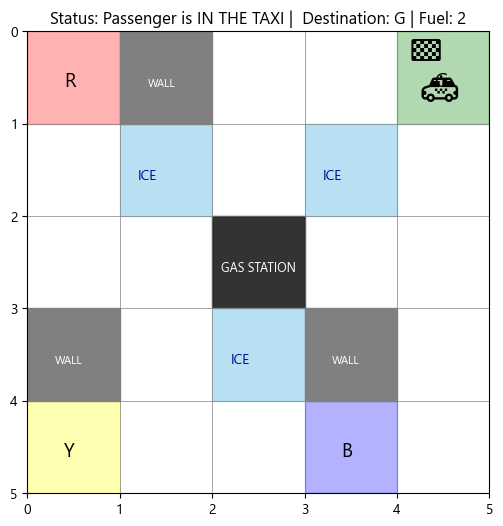

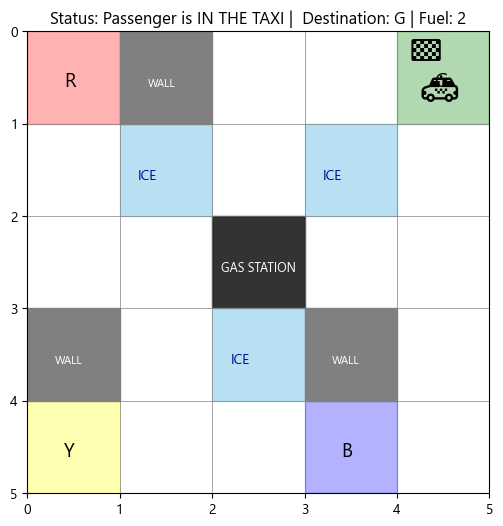

Mission Accomplished!


In [156]:
simulate_agent(env, agent)

In [157]:
test_performance(env, agent)

--- Test Results over 2000 episodes ---
Success Rate: 97.35%
Fuel Depletion Rate: 1.35%
Average Steps: 19.95
